credit::https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm

from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform=transforms.Compose(
    [transforms.ToTensor(),]
)
kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.37MB/s]


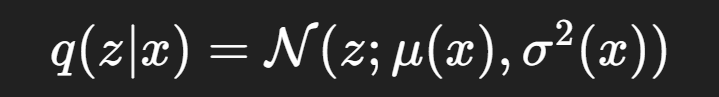

In [14]:
class Encoder(nn.Module):
  def __init__(self, input, hidden, latent):
    super().__init__()

    self.fc_input=nn.Linear(input, hidden)
    self.fc_input2=nn.Linear(hidden, hidden)
    self.fc_mean=nn.Linear(hidden, latent)
    self.fc_var=nn.Linear(hidden, latent)

    self.LeakyReLU=nn.LeakyReLU(0.2)

    self.training=True

  def forward(self, x):
    h=self.LeakyReLU(self.fc_input(x))
    h=self.LeakyReLU(self.fc_input2(h))
    mean=self.fc_mean(h)
    logvar=self.fc_var(h) #그냥 출력이 로그분산되게 학습이될거라고 가정
    return mean, logvar
# 인코더가 출력하는 평균 μ(x)와 로그분산 log(σ²(x))는 분포q의 파라미터
# q가 tractable하도록 정규분포로

In [5]:
class Decoder(nn.Module):
  def __init__(self, latent, hidden, out):
    super().__init__()
    self.fc_hidden=nn.Linear(latent, hidden)
    self.fc_hidden2=nn.Linear(hidden,hidden)
    self.fc_out=nn.Linear(hidden, out)

    self.LeakyReLU=nn.LeakyReLU(0.2)

  def forward(self, x):
    h= self.LeakyReLU(self.fc_hidden(x))
    h= self.LeakyReLU(self.fc_hidden2(h))

    x_hat=torch.softmax(self.fc_out(h))
    return x_hat # 확률값 리턴


In [10]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    super().__init__()
    self.Encoder=Encoder
    self.Decoder=Decoder

  def reparameterization(self, mean, var):
    epsilon=torch.randn_like(var).to(DEVICE) # var와 같은 shape이면서 표준정규분포에서 샘플링한
    z=mean+var*epsilon # ε을 곱하는 이유는 표준 정규분포에서 샘플링된 노이즈를 통해 z를 N(mean, var^2)에서 샘플링하기 위함
    return z # latent space가 평균 mean, 분산 var²를 따르는 정규분포를 따르도록 재파라미터화됨

  def forward(self, x):
    mean, log_var=self.Encoder(x)
    z=self.reparameterization(mean, torch.exp(0.5*log_var))
    x_hat=self.Decoder(z)
    return x_hat, mean, log_var


In [11]:
encoder = Encoder(input=x_dim, hidden=hidden_dim, latent=latent_dim)
decoder = Decoder(latent=latent_dim, hidden = hidden_dim, out = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

**1. binary_cross_entropy (BCE)**


*   이진 분류 (Binary Classification) 또는 Autoencoder 재구성 손실 (F.binary_cross_entropy(x_hat, x))
*   BCE=−∑[x⋅log(x
hat
​
 )+(1−x)⋅log(1−x
hat
​
 )]
*   타겟 x	0 또는 1인 값

**2. cross_entropy (CE)**


*   다중 클래스 분류 (F.cross_entropy(logits_per_image, labels))
*   타겟 labels	정수 인덱스 (예: [2, 0, 1])





VAE(Variational Autoencoder)에서는 latent 공간이 표준 정규분포를 따르도록 강제하지만, 그렇다고 해서 이 공간이 무의미해지는 것은 아닙니다. 왜냐하면 VAE는 두 가지 목표를 동시에 학습하기 때문입니다. 첫 번째는 입력 데이터를 다시 잘 복원하도록 학습하는 것이고, 두 번째는 latent 공간이 전체적으로 표준 정규분포에 가까워지도록 정렬하는 것입니다. 이 두 가지 제약이 함께 작용하면서, latent 공간의 각 위치는 여전히 의미 있는 정보를 담게 됩니다.

예를 들어, 모델 A가 숫자 이미지(MNIST)를 학습하고, 모델 B가 의류 이미지(Fashion-MNIST)를 학습했다고 가정해봅시다. 두 모델 모두 latent 공간을 표준 정규분포처럼 보이게 만들지만, 그 안에서 각 위치가 담고 있는 정보는 다릅니다. 즉, 같은 모양의 분포라도 그 안에 어떤 z가 어떤 이미지를 의미하는지는 각 모델의 학습 내용에 따라 달라지므로, 표면적으로는 같아 보여도 내부적인 의미는 전혀 다를 수 있습니다.

이러한 특성 덕분에 VAE는 무작위로 z를 샘플링하더라도 의미 있는 데이터를 생성할 수 있습니다. 학습된 latent 공간이 표준 정규분포를 따르도록 잘 정리되어 있기 때문에, 표준 정규분포에서 임의로 z를 뽑아도 그것이 어떤 의미 있는 데이터를 재구성하는 데 사용될 수 있습니다. 이게 바로 VAE의 중요한 장점 중 하나입니다.

요약하자면, 여러 모델이 표준 정규분포를 따른다고 해서 그 latent가 무의미해지는 것은 아닙니다. 재구성이라는 목표와 KL divergence 제약이 함께 작용하면서, latent 공간에는 여전히 의미가 담기게 됩니다. 따라서 무작위로 z를 샘플링해도 그로부터 자연스러운 데이터를 생성할 수 있는 것입니다.

In [12]:
from torch.optim import Adam
BCE_loss=nn.BCELoss()

def loss_function(x, x_hat, mean, log_var): # x: target, 0 또는 1인 값
  reproduction_loss=nn.functional.binary_cross_entropy(x_hat, x, reduction='sum') # 결과를 어떻게 합산 또는 평균할지를 정하는 옵션/ 'sum'	모든 손실을 합산해서 1개의 scalar로 반환
  KLD=-0.5*torch.sum(1+log_var-mean.pow(2)-log_var.exp()) # kld를 closed-form으 계산
  # 정규분포끼리는 공식화 가능
  # latent 공간을 표준 정규분포로 정렬하는 목표고, 그 오차가 kld
  return reproduction_loss+KLD

optimizer=Adam(model.parameters(),lr=lr)



In [16]:
model.train() # 모델을 학습 모드로 전환, 드롭아웃과 배치정규화 활성화됨

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")


In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')
show_image(generated_images, idx=12)